# 3D Reconstruction and Structure from Motion

Suppose we are given a series of images from a disaster situation. How can we begin to make sense of the contents of the image? Typically this involves answering two questions:

- _What_ is in an image (e.g. debris, buildings, etc.)?
- _Where_ are these things located _in 3D space_ ?

We are first going to set the first question aside and focus entirely on the second. This will be the first in two lectures on so called "structure from motion", which is the idea that you can recreate a 3D scene from a series of 2D images by taking those images from a moving camera. Today's lecture will focus on the theory of 3D reconstruction and how to implement it. Tomorrow's lecture will focus on a real world example of structure from motion, and we will work to assign GPS coordinates to pixels on an image. 

We will first start with two images and work our way up to multiple images.

## The Camera Model: 

Let's first introduce the model that we will be basing our analysis on. For this session, we will be using the _pinhole model_ of a camera, depicted in the following picture:

<img src="notebook_images/pinhole.png" width="300"  />

In this model of the camera, light rays are reflected off of an object (in this case a kettle), they pass through an infinitesimally small pinhole, and arrive at the opposite wall of the camera, creating a photo-negative (think upside down) image of the object. The pinhole is located at a point called the _center of projection_. Because the image on the actual camera is a photo-negative, we typically instead center our reference frame on the center of projection and work as if the image were on the opposite side, which we will call the _image plane_. The distance _f_ between the center of projection and the image plane is called the _focal length_ which is usually measured in millimeters. On the image plane, the center of the plane is called the _principal point_ and the line that connects the center of projection and the principal point is called the _principal axis_.

We can align our coordinate frame as follows: let's center our coordinate system such that the origin is the center of projection, let's align the Z-axis such that it passes through principal axis, and let's align the X- and Y-axis such that the X-axis goes along the horizonal direction of the image plane and the Y-axis goes along the vertical direction of the image plane. Note that X increases to the right, but Y increases *downward*. This is shown in the following image:

<img src="notebook_images/reference_frame.png" width="500"  />

The image plane is given by a _uv-plane_ that is centered on the principal point and is orthogonal to the principal axis. Note that cameras typically measure coordinates starting from the upper-left corner, and increasing to the left and downwards (which motivates our decision to align our Y axis downwards). Furthermore, note that cameras cannot capture an image with perfect precision. Rather, they are composed of small elements called _pixels_ that vary in intensity in order to capture the scene. Therefore, we would rather operate on the discrete pixel plane, which we will call the lowercase xy-plane. You can compare both planes in the image below:

<img src="notebook_images/xy_plane.png" width="500"  />

All objects create a projection on the xy-plane, which is what we actually see on the image. For example, the point $M$ on the kettle is projected onto the xy-plane on the point _m_. Suppose we have the coordinates ($X$, $Y$, $Z$) of the point $M$. **What are the coordinates on the xy-plane of the point $m$?** State your answer in terms of $\alpha$ (the focal length measured in pixels, not millimeters), $p_x$ and $p_y$ (the coordinates of the principal point $p$ in the xy-plane), and $X$, $Y$ and $Z$, the coordinates of the point $M$.

<details>
    <summary>ANSWER</summary>
    We can use geometry to arrive at the answer. Note that $C$, $p$ and $m$ form a similar triangle with $C$, $Z$ and $M$. Therefore, $\frac{x-p_x}{\alpha} = \frac{X}{Z}$ and $\frac{y-p_y}{\alpha} = \frac{Y}{Z}$. Now it's a matter of solving: $x = \alpha\frac{X}{Z} + p_x$ and $y = \alpha\frac{Y}{Z} + p_y$
</details>


### List of variables used in this lesson
| Variable |                                               Meaning                                              |
|:--------:|:--------------------------------------------------------------------------------------------------:|
|     M    |                                         A point in 3D space                                        |
|  m1, m2  |                                  Projection of M on image 1 and 2                                  |
|  C1, C2  |                             Center of camera 1, 2 (a point in 3D space)                            |
|     p    |         A point on the z axis of C (directly in front of it) at the center of a given photo        |
|     a    |                                      Focal length of a camera                                      |
|     R    |                                     Rotation of a camera image                                     |
|     t    |                                    Translation of a camera image                                   |
|     K    | A intrinsic matrix used to calculate a camera's offset, a function of its focal length and point p |

## The Problem: Depth Ambiguity

Scene reconstruction requires us to go the other way around: we know the coordinates ($x$, $y$) of $m$ and we want the ($X$, $Y$, $Z$) coordinates of the point $M$. This presents a problem: we have two equations and three unknowns. Specifically, there is an ambiguity in the depth $Z$ that is impossible to resolve with just one image. Therefore, the point $M$ can be anywhere along the ray connecting the center of projection and the point $m$. This is shown in the image below:

<img src="notebook_images/ambiguity.png" width="150"  />

However, this can be remediated by adding a second image into the equation. This is because, assuming we have perfect cameras*, the rays connecting both centers of projection to the point $M$ should only intersect at one point, as is shown in the image below:

<img src="notebook_images/two_images.png" width="250"  />

Let's assume that $C_1$ and $C_2$ are both from the same camera but different locations. Furthermore, let's center our coordinate system such that $C_1$ is at the origin. What do we need in order to find the coordinates of point $M$ ? 
- The corresponding points $m_1$ and $m_2$
- The focal length $\alpha$ and the coordinates $p_x$ and $p_y$. Because these are internal to the camera, we call these the _intrinsic parameters_.
- The relative rotation $R$ and translation $t$ of $C_2$ with respect to $C_1$. Here, $R$ is a 3x3 matrix and $t$ is a 3x1 vector. We call $R$ and $t$ the _extrinsic parameters_. 

\* The perfect cameras assumption is actually critical. To see why, imagine if by some measurement error (imperfect lens, pixel accuracy, etc), $m_2$ is slightly off. **What would happen in the previous example?**

<details>
    <summary>ANSWER</summary>
    The rays corresponding to points $m_1$ and $m_2$ will not intersect, so there is no solution to this problem! 
</details>

In practice, no camera is actually perfect. There are tools that work under the hood to mitigate this. We will briefly discuss them, but will not go in depth. 

Let's get started!

In [70]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import sys

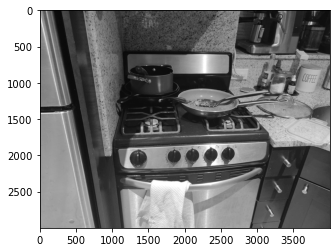

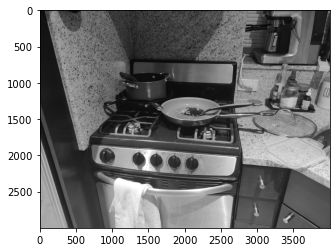

In [71]:
%matplotlib inline
# Load and display the two images
img1 = cv2.imread("kitchen_example/images/img1.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img1, cmap='gray')
plt.show()

img2 = cv2.imread("kitchen_example/images/img2.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap='gray')
plt.show()

## Corresponding points

Our first task is to find the points $m_1$ and $m_2$. Note that it's not just a matter of finding arbitrary points, but also of ensuring the $m_1$ is actually pointing to the same object $M$ as $m_2$. Of course, one way to do this is to manually go through both images and match points on one image with points on the other. This is not a scalable solution as you increase the number of images. To this end, experts in computer vision work with the concept of _features_ which represent points of interest within an image. To understand how features work, consider the image below. **Which of the options, A through F are most easily identifiable in the image?**

<img src="notebook_images/feature_building.jpg" width="400"  />

<details>
    <summary>ANSWER</summary>
    A and B are the hardest because they could be anywhere on the surface, so surfaces are not good. C and D are a bit easier, because edges are more immediately recognizable. However, the points can still be anywhere along the edge. E and F are the easiest, since there is only one corner that looks like them. What this shows is that corners are good points to track, followed by edges and finally surfaces.  
</details>

Features, therefore, are typically corners that are automatically extracted based on color differences around the corner. Features are composed of both the _coordinates_ of the point of interest as well as a _descriptor_ of what those points look like.

There are all sorts of features that will do the job. Here, we will show ORB features, which were created by the makers of OpenCV. We first extract the features and then match them with a feature in the opposite image that has the closest descriptor. It's worth noting that most of these matches will not be very good, so we only want to keep the best matches we have. 

### Feature extraction

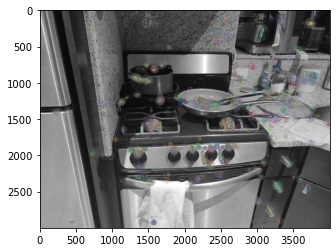

In [72]:
MAX_FEATURES = 5000

# creating the ORB feature extractor
orb = cv2.ORB_create(MAX_FEATURES)

# creating feature points for first and second images
kp1, dc1 = orb.detectAndCompute(img1, None)
kp2, dc2 = orb.detectAndCompute(img2, None)

img1_ORB = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1_ORB)
plt.show()

### Feature matching

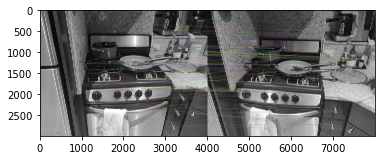

In [73]:
# most matches are not very good, so we want to keep only the best ones.
# here, we keep only the top 20%
GOOD_MATCH_PERCENT = 0.2

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# match descriptors
matches = bf.match(dc1, dc2)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove worst matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

img_match = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
plt.imshow(img_match)
plt.show()

pts1 = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
pts2 = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

## Intrinsic parameters

We now proceed to obtain the intrinsic parameters. We have already seen that we can gather important data about the image by looking at its metadata. We can do something similar here:

In [74]:
import exifread

with open("kitchen_example/images/img1.jpg", 'rb') as image_file:
    tags = exifread.process_file(image_file, details=False)
    print(tags["EXIF FocalLength"])
    print(img1.shape)

951/200
(3000, 4000)


It might seem tempting to take the focal length as is, and to take the height and width of the image, divide by two and call that the coordinates of the principal point. While this might certainly be a start if you have no other options, there are some limitations to take into account. First, recall that the focal length here is measured in millimeters, but we need the length in pixels $\alpha = m*f$, where $m$ is the size in millimeters of each pixel. This information is rarely found in the metadata. Usually, if you want to get the focal length in pixels just from the metadata, you would have to find the camera specifications online and make the conversion of millimeters to pixels. Also, the focal length is typically rounded to the nearest integer in the metadata, further complicating matters. 

Second, because of manufacturing constraints in positioning the sensor the principal point is always off from the middle of an image by a few pixels. While the middle of an image is most likely a good approximation, the error will continue to add up as you go farther away from the camera center. 

Finally, even if you have the focal length and principal point coordinates, the reconstruction must account for _distortion_. Distortion typically comes from imperfect lenses. The most well known form of distortion is _radial distortion_. This has the effect of making straight lines bulge outwards the farther away you are from the center. The figure below shows an example of this: 

<img src="notebook_images/distortion.jpg" width="300"  />

Distortion is rarely in the image metadata. Sometimes cameras have distortion control that corrects for distortion when it's taking the image, so you don't have to worry about it. Still, this is relatively rare and it does not show up in the metadata whether distortion control was applied. So if you're not familiar with the camera you're using, you're still in the dark.

One way to get around this is to perform explicit camera calibration. A common way to do this is to map points with a known 3D-to-2D correspondence (like a chessboard) and perform an optimization to correct for the distortion. How this typically works is by assigning coordinates to the inner corners of the camera (e.g. the top left corner will be (0, 0, 0), the one on the right might be (1, 0, 0), the one below would be (0, 1, 0)), and then choosing the focal length, principal point and distortion parameters that best explain deviations in the expected 2D coordinates. Typically you have to take something on the order of 20-30 images of a chessboard from slightly varying locations for this procedure to work.

corners found!


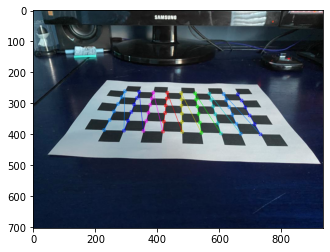

corners found!


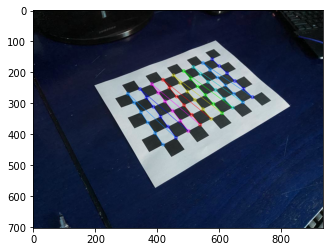

corners found!


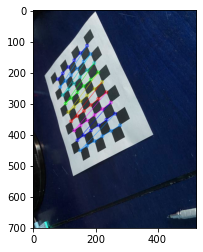

corners found!


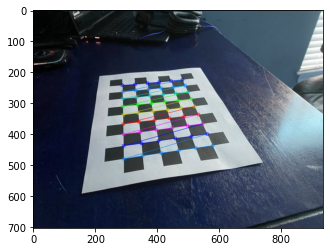

corners found!


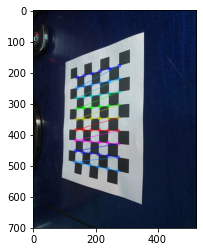

corners found!


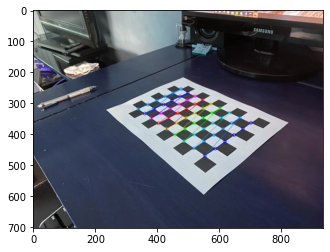

corners found!


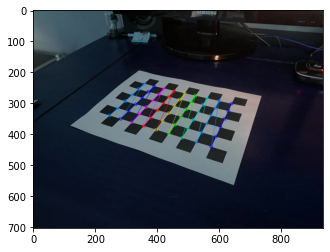

corners found!


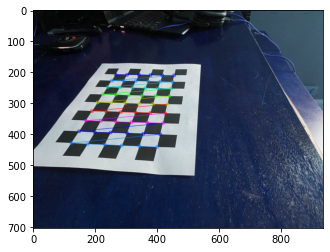

corners found!


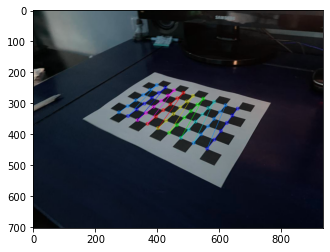

corners found!


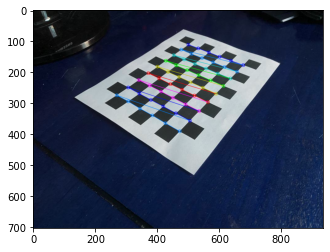

corners found!


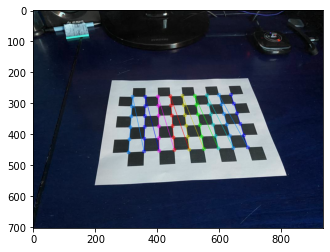

corners found!


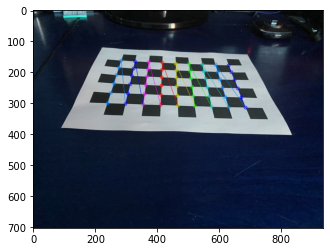

corners found!


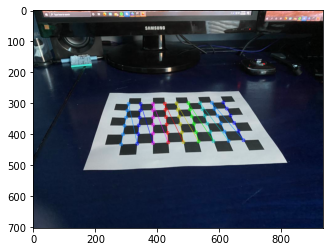

corners found!


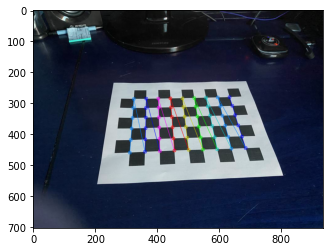

corners found!


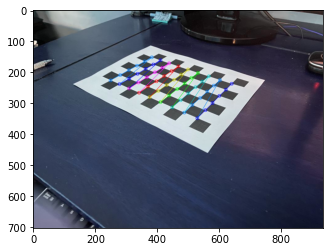

corners found!


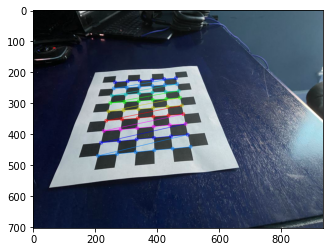

corners found!


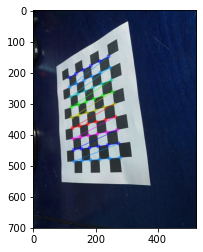

corners found!


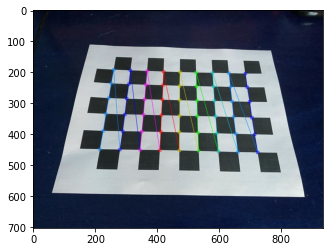

corners found!


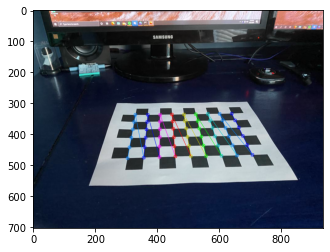

[[685.18558965   0.         448.14625141]
 [  0.         647.63403902 328.96392044]
 [  0.           0.           1.        ]]
[[ 0.27783889 -1.34000107 -0.0031271  -0.00651972  1.2029155 ]]


In [75]:
import glob
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('chessboard/*.JPG')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (6,9),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        print("corners found!")
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (6,9), corners2,ret)
        plt.imshow(img, cmap="gray")
        plt.show()
    else:
        print("corners not found, trying next image.")

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print(mtx)
np.save('camera_mat.npy', mtx)
print(dist)



Usually the intrinsic parameters are stored as a matrix, called the *intrinsic matrix*. The form of the intrinsic matrix is as follows:

\begin{equation}
K = \begin{bmatrix}
\alpha_x & 0 & p_x\\
0 & \alpha_y & p_y\\
0 & 0 & 1
\end{bmatrix}
\end{equation}

I loaded the camera matrix from my phone below. Notice that the coordinates of the principal point are close to, but not quite, the middle of the image. Also notice that we introduced $\alpha_x$ and $\alpha_y$, even though we've only worked with $\alpha$ thus far. This is a more general notation, and it takes into account the possibility that cameras might not have square pixels. If one side of a pixel is larger than the other, it makes more sense to talk about focal length measured in pixel width or height. Still, cameras typically have square pixels, and this is reflected in the fact that $\alpha_x$ is very close to $\alpha_y$, so we can chalk up the discrepancy to measurement error.

As a final note, some very specialized cameras have non-rectangular pixels. It turns out $K$ can account for that by changing the value of $K_{1, 2}$, otherwise known as the skew. For most cameras, you can assume it equals 0.

In [76]:
# the cell above takes a very long time to run. I already ran it and saved the matrix.
K = np.load('camera_mat.npy')
print(K)

[[685.18558965   0.         448.14625141]
 [  0.         647.63403902 328.96392044]
 [  0.           0.           1.        ]]


### Exercise
Print out the chessboard that was provided to you in chessboard_original/ (or use your own chessboard). Using your phone (or whatever other camera), take 20 or so photos of the chessboard lying on a flat surface and upload them to the chessboard/ directory.

Uncomment the cell with the callibration code and run the callibration with your images. Compare the values in the estimated camera matrix with the values you would have expected. How similar are they to the expected values? What is the size of a pixel in your camera in millimeters?

In [ ]:
alpha = m * f where m is mm per pixel

## Extrinsic parameters

We now need to find the rotation and translation $R$ and $t$ of both cameras. To reiterate, $t$ is a 3x1 vector that denotes the distance from the origin in $X$, $Y$ and $Z$\*. $R$ is a 3x3 matrix that encodes the rotation of the camera. We made our lives a bit easier by centering the coordinate system on the first camera, such that $t_1 = [0, 0, 0]'$ and $R_1$ is the identity matrix. Remember that we also aligned the coordinate system such that the vector $[0, 0, 1]'$ is in the direction that the camera is pointing. One way to interpret the rotation matrix $R_2$ is by saying that it is the matrix that rotates the vector $[0, 0, 1]'$ into the vector that is aligned with the direction of the second camera. 

One of the most amazing results in multiview geometry is that $R_2$ and $t_2$ can both be recovered (up to scale, in the case of $t_2$) just by knowing the corresponding points and the intrinsic parameters. At a very high level, this is a key tenet of something called _epipolar geometry_. Consider images (a) and (b) below. On the image you will find random corresponding points between the two images. On image (a), clearly the camera that took (b) is somewhere to the right. Imagine we could extend (a) so much that you could actually see the camera that took (b), and let's draw a line between the camera that took (b) and all of the corresponding points. What you would find is a series of lines, called epipolar lines, that all converge at the camera that took (b), whose point is called the epipole. This is what we see in (c) and (d). 

<img src="notebook_images/epipolar.jpg" width="500"  />

(source: https://www.youtube.com/watch?v=QzYn0OPO0Yw)

It turns out there is a matrix called the _fundamental matrix_ that encodes this information. This matrix can be estimated using the corresponding points we got before. Furthermore, by combining it with the intrinsic parameters, we get another matrix called the _essential matrix_ which can then be decomposed into a relative rotation and translation $R_2$ and $t_2$, which is what we're after! This is of course a criminally high level summary of how this works. For more information, this is an excellent source: https://www.youtube.com/watch?v=QzYn0OPO0Yw.

\* This is actually a bit incorrect. $t$ represents the vector connecting the center of projection to the origin *from the point of view of the camera being considered*, not the first camera. Still, the general idea is that it denotes displacement.

In [63]:
# converting to pixel coordinates
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Estimate the essential matrix
E, mask = cv2.findEssentialMat(pts1,pts2,K)

# We select only inlier points
pts1_inliers = (pts1[mask.ravel()==1])
pts2_inliers = (pts2[mask.ravel()==1])

In [64]:
# Recover pose using what we've learned so far
retval, R, t, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)
print(R)
print(t)

[[ 0.99856516 -0.01428109  0.05161077]
 [ 0.01552536  0.99959645 -0.02378877]
 [-0.05125022  0.02455592  0.99838391]]
[[-0.99493378]
 [ 0.073958  ]
 [ 0.0680954 ]]


## Finalizing the reconstruction

We now have everything we need to reconstruct the scene in 3D! We have corresponding points in two images, the intrinsic parameters of the camera and the extrinsic parameters as the camera took the two images. There is just one caveat. Remember that the value $t_2$ that we obtained was up to scale. It turns out that our entire scene is scaled such that the length of $t_2 = 1$. This means that while the relative distances between the reconstructed points are conserved, the absolute positions are not. 

Because we want to take advantage of visualization software that currently exists, we will use a package called OpenSfM (https://github.com/mapillary/OpenSfM). OpenSfM automatically goes through the trouble of extracting the features, matching them, finding the poses of the cameras and doing the triangulation. One thing it does not do, however, is the camera calibration. We can either provide our own intrinsic camera parameters or we can let the algorithm take its best guess through a process called _bundle adjustment_. Bundle adjustment essentially works by identifying the _reprojection error_ (the error in reprojecting the reconstructed 3D features back onto the image) and slightly modifying the camera positions and parameters, as well as the positions of the features, so that the error is minimized. 

As a final note, what do we do when we have more than three images? Clearly if you can find the camera pose of image 2 relative to image 1, then it's possible to find the pose of image 3 relative to image 2. Therefore, multiple images can take part in a reconstruction. Here, bundle adjustment is very important to ensure that errors in the reconstruction do not keep adding up.

Here are the steps to reconstruct a scene:
- Extract the focal length from the metadata
- Detect features from images (in this particular case, we are using so called HAHOG features)
- Match features across images
- Reconstruct the scene using the inferred rotations and translations
- Visualize the scene

OpenSfM has a very good command line interface, so we'll move to the terminal for this portion. However, the commands are on the following cell in case you want to refer back to them.

In [65]:
# Take initial guess of intrinsic parameters through metadata
!opensfm extract_metadata kitchen_example/

# Detect features points 
!opensfm detect_features kitchen_example/

# Match feature points across images
!opensfm match_features kitchen_example/

# This creates "tracks" for the features. That is to say, if a feature in image 1 is matched with one in image 2,
# and in turn that one is matched with one in image 3, then it links the matches between 1 and 3. In this case, 
# it does not matter since we only have two images
!opensfm create_tracks kitchen_example/

# Calculates the essential matrix, the camera pose and the reconstructed feature points
!opensfm reconstruct kitchen_example/

# For visualization using Open3D
!opensfm export_ply kitchen_example/

2020-07-20 19:43:29,347 INFO: Extracting EXIF for img1.jpg
2020-07-20 19:43:29,390 ERROR: The rational "0/0" of tag "GPS GPSTimeStamp" at index 0 caused a division by zero error
2020-07-20 19:43:29,390 INFO: The GPS time stamp in image file "kitchen_example/images/img1.jpg" is invalid. Falling back to DateTime*
2020-07-20 19:43:29,391 DEBUG: No GPS time stamp and no time zone offset in image file "kitchen_example/images/img1.jpg"
2020-07-20 19:43:29,391 DEBUG: Naively assuming UTC on "EXIF DateTimeOriginal" in image file "kitchen_example/images/img1.jpg"
2020-07-20 19:43:29,391 INFO: Extracting EXIF for img2.jpg
2020-07-20 19:43:29,436 ERROR: The rational "0/0" of tag "GPS GPSTimeStamp" at index 0 caused a division by zero error
2020-07-20 19:43:29,437 INFO: The GPS time stamp in image file "kitchen_example/images/img2.jpg" is invalid. Falling back to DateTime*
2020-07-20 19:43:29,437 DEBUG: No GPS time stamp and no time zone offset in image file "kitchen_example/images/img2.jpg"
2020-

In [67]:
!opensfm undistort kitchen_example/

!opensfm compute_depthmaps kitchen_example/

2020-07-20 19:51:37,630 DEBUG: Undistorting the reconstruction
2020-07-20 19:51:37,645 DEBUG: Undistorting image img1.jpg
2020-07-20 19:51:40,326 DEBUG: Undistorting image img2.jpg
2020-07-20 19:51:45,266 INFO: Computing neighbors
2020-07-20 19:51:45,283 INFO: Computing depthmap for image img1.jpg with PATCH_MATCH_SAMPLE
2020-07-20 19:52:09,554 INFO: Computing depthmap for image img2.jpg with PATCH_MATCH_SAMPLE
2020-07-20 19:52:32,060 INFO: Cleaning depthmap for image img1.jpg
2020-07-20 19:52:34,332 INFO: Cleaning depthmap for image img2.jpg
2020-07-20 19:52:36,600 INFO: Pruning depthmap for image img1.jpg
2020-07-20 19:52:37,990 INFO: Pruning depthmap for image img2.jpg
2020-07-20 19:52:39,421 INFO: Merging depthmaps


In [66]:
import open3d as o3d
from open3d import JVisualizer

pcd = o3d.io.read_point_cloud("kitchen_example/reconstruction.ply")
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

# UNCOMMENT ONLY IF RUNNING LOCALLY
# o3d.visualization.draw_geometries([pcd])

JVisualizer with 1 geometries

In [69]:
import open3d as o3d
from open3d import JVisualizer

pcd = o3d.io.read_point_cloud("kitchen_example/undistorted/depthmaps/merged.ply")
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

# UNCOMMENT ONLY IF RUNNING LOCALLY
# o3d.visualization.draw_geometries([pcd])

JVisualizer with 1 geometries

### Exercise
We will now let you try out 3D reconstruction for yourself using OpenSfM! First, we need to make sure you have the proper file structure to make this work. Create a directory called "workspace/" (or whatever else you want). In that directory, create a directory called "images/". From the kitchen_example/ directory, copy "config.yaml" and paste it in workspace/. Take two or more images of your work space and upload them to workspace/images. Now run the commands above to reconstruct the scene and visualize it. Is the reconstruction accurate? What about your scene might make it difficult for the reconstruction to work well?

Go to workspace/reports and examine the files there. They will give you a sense of how many features were extracted, how many features were matched, and whether some reconstructions are only partial. Do you have multiple partial reconstructions or one larger reconstruction? If you have partial reconstructions, why do you think that is?

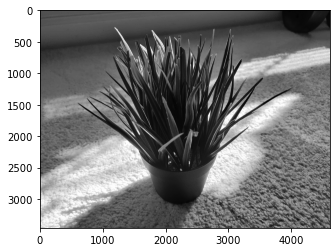

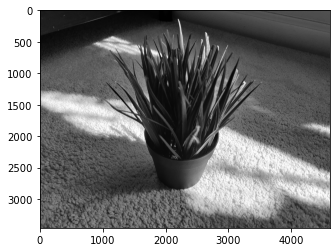

'plant3 = cv2.imread("workspace/images/plant3.jpg", cv2.IMREAD_GRAYSCALE)\nplt.imshow(plant3, cmap=\'gray\')\nplt.show()\n\nplant4 = cv2.imread("workspace/images/plant4.jpg", cv2.IMREAD_GRAYSCALE)\nplt.imshow(plant4, cmap=\'gray\')\nplt.show()'

In [97]:
%matplotlib inline
# Load and display the two images
plant1 = cv2.imread("workspace/images/plant1.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(plant1, cmap='gray')
plt.show()

plant2 = cv2.imread("workspace/images/plant2.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(plant2, cmap='gray')
plt.show()

'''plant3 = cv2.imread("workspace/images/plant3.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(plant3, cmap='gray')
plt.show()

plant4 = cv2.imread("workspace/images/plant4.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(plant4, cmap='gray')
plt.show()'''

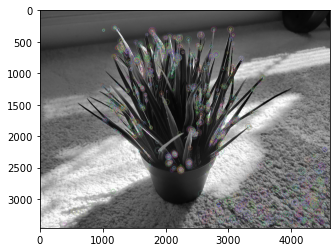

In [98]:
MAX_FEATURES = 5000

# creating the ORB feature extractor
orb = cv2.ORB_create(MAX_FEATURES)

# creating feature points for first and second images
kp1, dc1 = orb.detectAndCompute(plant1, None)
kp2, dc2 = orb.detectAndCompute(plant2, None)

plant1_ORB = cv2.drawKeypoints(plant1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(plant1_ORB)
plt.show()

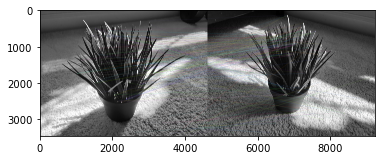

In [99]:
# most matches are not very good, so we want to keep only the best ones.
# here, we keep only the top 20%
GOOD_MATCH_PERCENT = 0.2

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# match descriptors
matches = bf.match(dc1, dc2)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove worst matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

img_match = cv2.drawMatches(plant1,kp1,plant2,kp2,matches,None, flags=2)
plt.imshow(img_match)
plt.show()

pts1 = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
pts2 = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

In [100]:
# converting to pixel coordinates
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Estimate the essential matrix
E, mask = cv2.findEssentialMat(pts1,pts2,K)

# We select only inlier points
pts1_inliers = (pts1[mask.ravel()==1])
pts2_inliers = (pts2[mask.ravel()==1])

In [101]:
# Take initial guess of intrinsic parameters through metadata
!opensfm extract_metadata workspace/

# Detect features points 
!opensfm detect_features workspace/

# Match feature points across images
!opensfm match_features workspace/

# This creates "tracks" for the features. That is to say, if a feature in image 1 is matched with one in image 2,
# and in turn that one is matched with one in image 3, then it links the matches between 1 and 3. In this case, 
# it does not matter since we only have two images
!opensfm create_tracks workspace/

# Calculates the essential matrix, the camera pose and the reconstructed feature points
!opensfm reconstruct workspace/

# For visualization using Open3D
!opensfm export_ply workspace/

2020-07-20 20:30:29,520 INFO: Loading existing EXIF for plant2.jpg
2020-07-20 20:30:29,521 INFO: Loading existing EXIF for plant1.jpg
2020-07-20 20:30:31,451 INFO: Skip recomputing ROOT_HAHOG features for image plant2.jpg
2020-07-20 20:30:31,451 INFO: Skip recomputing ROOT_HAHOG features for image plant1.jpg
2020-07-20 20:30:33,435 INFO: Matching 1 image pairs
2020-07-20 20:30:33,440 INFO: Computing pair matching with 1 processes
2020-07-20 20:30:33,465 DEBUG: No segmentation for plant2.jpg, no features masked.
2020-07-20 20:30:33,466 DEBUG: No segmentation for plant1.jpg, no features masked.
2020-07-20 20:30:34,000 DEBUG: Matching plant2.jpg and plant1.jpg.  Matcher: FLANN (symmetric) T-desc: 0.534 T-robust: 0.001 T-total: 0.535 Matches: 113 Robust: 102 Success: True
2020-07-20 20:30:34,000 DEBUG: Image plant2.jpg matches: 1 out of 1
2020-07-20 20:30:34,001 DEBUG: Image plant1.jpg matches: 0 out of 0
2020-07-20 20:30:34,001 INFO: Matched 1 pairs for 2 ref_images (perspective-perspecti

In [102]:
!opensfm undistort workspace/

!opensfm compute_depthmaps workspace/

2020-07-20 20:30:42,086 DEBUG: Undistorting the reconstruction
2020-07-20 20:30:42,091 DEBUG: Undistorting image plant1.jpg
2020-07-20 20:30:45,329 DEBUG: Undistorting image plant2.jpg
2020-07-20 20:30:50,495 INFO: Computing neighbors
2020-07-20 20:30:50,501 INFO: Using precomputed raw depthmap plant1.jpg
2020-07-20 20:30:50,501 INFO: Using precomputed raw depthmap plant2.jpg
2020-07-20 20:30:50,501 INFO: Using precomputed clean depthmap plant1.jpg
2020-07-20 20:30:50,501 INFO: Using precomputed clean depthmap plant2.jpg
2020-07-20 20:30:50,501 INFO: Using precomputed pruned depthmap plant1.jpg
2020-07-20 20:30:50,501 INFO: Using precomputed pruned depthmap plant2.jpg
2020-07-20 20:30:50,501 INFO: Merging depthmaps


In [107]:
import open3d as o3d
from open3d import JVisualizer

pcd = o3d.io.read_point_cloud("workspace/undistorted/depthmaps/merged.ply")
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

# UNCOMMENT ONLY IF RUNNING LOCALLY
# o3d.visualization.draw_geometries([pcd])

JVisualizer with 1 geometries

In [105]:
import open3d as o3d
from open3d import JVisualizer

pcd = o3d.io.read_point_cloud("workspace/reconstruction.ply")
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

# UNCOMMENT ONLY IF RUNNING LOCALLY
# o3d.visualization.draw_geometries([pcd])

JVisualizer with 1 geometries